# Spread count of bounding boxes with Bivariate Gaussian into cells

In this notebook it is shown how to split the count of an object in an image into cells according to a bivariate normal distribution along the x and y axes of the box. It is possible to use the structure of this notebook to apply different distributions or curves to split the count, it is just a matter of replacing the integral computation with the desired one. 

## Bivariate Normal Distribution

The bivariate normal distribution can be defined as the probability density function (PDF) of two variables X and Y that are linear functions of the same independent normal random variables (adapted from Wolfram):

<br>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fca42ffd6e6daf34cbe42d814acd3c353a826c8f"/>
<br>

The mean is a vector $\mu \in \mathbf{R}^2$ and the variance is now defined throug a covariance matrix $\Sigma \in \mathbf{S}^2_{++}$.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1d6238c86bf561c952e0560e6f6ad3591278fb82"/>
<br>

This is how it looks like in a 3D plot moving according to the changes of the mean:

<br>
<img src="https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2015/09/Bivariate41.gif"/>

And this is how it looks like if we consider the 2 axes separatly:

<br>
<img src="https://i.stack.imgur.com/WbUim.png" height="400" width="400"/>
<br>
<br>


## Plot a Bivariate Normal Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import mvn
import cv2

%matplotlib inline

In [2]:
#Parameters to set
mu_x = 0
sigma_x = np.sqrt(3)

mu_y = 0
sigma_y = np.sqrt(15)

In [3]:
#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
Z = bivariate_normal(X,Y,sigma_x,sigma_y,mu_x,mu_y)

/home/luca/anaconda3/envs/count/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  """


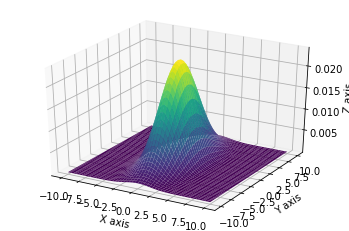

In [4]:
#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z,cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

## Compute the volume under the surface

Create a multivariate normal distribution using the SCipy Statistical library

In [5]:
from scipy.stats import mvn

Define mean and covariance. We assume a grid where to build our gaussian in the intervals $\mathbf{x} \in {[0, 10]}, \mathbf{y} \in {[0, 20]}$. To obtain 0.997 of the CDF in our defined region, we have to set $\sigma$ = 1/3\*1/2\*side, so $\Sigma$ = [[(5/3)\*\*2,0],[0,(10/3)\*\*2]].

In [6]:
mu = np.array([5, 10])
S = np.array([[(5/3)**2,0],[0,(10/3)**2]])

Define lower and upper bounds of the region where to compute the CDF

In [7]:
low = np.array([5-5/3, 10-10/3]) 
upp = np.array([5+5/3, 10+10/3])

In [8]:
p,i = mvn.mvnun(low,upp,mu,S)

In [ ]:
print(p)

0.4660649426743926


## Create the cells and split the count of one bounding box

Create a grid over a certain input shape of a standard input image. Define a random bounding box and a function that per each cell return the coordinates of intersection of the bounding box and itself to compute the CDF of the Bivariate Normal Distribution

In [ ]:
# Import an image and define the bounding box for one of its objects
image = cv2.imread('../trial_files/images/000001.jpg')
bbox = [48,240,195,371]

input_shape = image.shape
grid_division = (3,3)

print(input_shape)

x_coords = np.linspace(0, input_shape[1], grid_division[0] + 1)
y_coords = np.linspace(0, input_shape[0], grid_division[1] + 1)
grids = []
for i in range(grid_division[0]):
    for j in range(grid_division[1]):
        grids.append([x_coords[i], y_coords[j], x_coords[i+1], y_coords[j+1] ])
grids = np.array(grids)

(500, 353, 3)


In [ ]:
# Takes 2 lists with the four coordinates of top left and bottom right corners of the rectangle
# Returns the coordinates of the intersection rectangle as lower and upper bounds of the region 
# to compute the integral

def rectangles_intersection (A, B):
    
    if A[0] > B[2] or A[1] > B[3] or A[2] < B[0] or A[3] < B[1]:
        return None, None
    else: 
        return np.array([max(A[0], B[0]), max(A[1], B[1])]), np.array([min(A[2], B[2]), min(A[3], B[3])])    

Define a function to plot the image with the grid division and the bounding box with the count split in the cells

In [ ]:
def plot_split_count(image, grid_division, grids, bbox, counter):
    
    img = image.copy()
    output = image.copy()
    
     # Draw BBox
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),(0, 0, 255), -1)
    cv2.addWeighted(img, 0.4, output, 0.6,0, output)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.55
    thickness = 1
    color = (255, 255, 255)
    
    # Draw grids and count per cell
    for i, g in enumerate(grids):
        output[int(g[1]),:] = 255
        output[:,int(g[0])] = 255
        text = '{:.3f}'.format(counter[i])
        size = cv2.getTextSize(text, font, font_scale, thickness)
        coords = (int(g[2]-g[0] + g[0] - size[0][0]), int(g[3]-g[1] + g[1] - size[0][1]))
        cv2.putText(output, text, coords, font, font_scale,(255,255,255),thickness)
        
    cv2.imshow('image',output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()    

Generate a Bivariate Normal Distribution over the bounding box region

In [ ]:
# Define mu and covariance matrix
mu = np.array([(bbox[2]-bbox[0])/2 + bbox[0], (bbox[3]-bbox[1])/2 + bbox[1]])
S = np.array([[((bbox[2]-bbox[0])/6)**2,0],[0,((bbox[3]-bbox[1])/6)**2]])
norm_coeff = mvn.mvnun(np.array(bbox[:2]),np.array(bbox[2:]),mu,S)

print("mu = \n", mu)
print("S = \n", S)
print("Normalization factor: \n", norm_coeff[0])

mu = 
 [121.5 305.5]
S = 
 [[600.25         0.        ]
 [  0.         476.69444444]]
Normalization factor: 
 0.9946076967722628


In [ ]:
counter = np.zeros(grids.shape[0])
for idx, g in enumerate(grids):
    low, upp = rectangles_intersection(g, bbox)
    if low is None:
        continue
    p,i = mvn.mvnun(low,upp,mu,S)
    counter[idx] = p / norm_coeff[0]
    
print(np.reshape(counter, grid_division).T)

[[0.         0.         0.        ]
 [0.39385172 0.50603951 0.        ]
 [0.0438142  0.05629458 0.        ]]


In [ ]:
plot_split_count(image, grid_division, grids, bbox, counter)